#Least Squares GANs Implementation
                                                    - K.Krishna Dhakshin

##Import Essential Stuff

In [0]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [0]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Loading DataSets (CIFAR10/MNIST)

In [0]:
bool = False  #set to true for CIFAR10 and false for MNIST

In [0]:
if bool:
  trainset = dset.CIFAR10(root='./cifar10', train=True, transform=transforms.Compose([transforms.Resize((32, 32)),  transforms.ToTensor(), transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))]), download=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
  nc = 3
else:
  trainset = dset.MNIST(root='./mnist', train=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean = (0.5,), std = (0.5,))]), download=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
  nc = 1

##Visualizing DataSet

In [0]:
batch = next(iter(trainloader))
vutils.make_grid(batch[0]).size()

torch.Size([3, 444, 274])

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

100

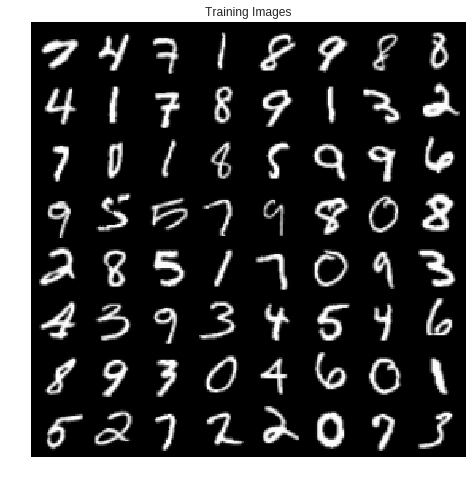

In [0]:
batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
batch[0].size(0)

## Designing the GANs Model

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [0]:
netG = Generator()
netG.cuda()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [0]:
netD = Discriminator()
netD.cuda()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.3)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Dropout2d(p=0.3)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace)
    (10): Dropout2d(p=0.3)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
netG.apply(weights_init)
print(netG)
netD.apply(weights_init)
print(netD)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=

In [0]:
a = 0
b = 1
c = 1

In [0]:
criterion = nn.MSELoss()
optimizerD = optim.SGD(netD.parameters(), lr=0.02)
optimizerG = optim.SGD(netG.parameters(), lr=0.02)

In [0]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [0]:
device

device(type='cuda', index=0)

##Training Network

In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

In [0]:
for epoch in range(100):
    for i, data in enumerate(trainloader, 0):
        netD.zero_grad()
        data[0] = data[0].cuda()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), b, device=device)
        output = netD(torch.cuda.FloatTensor(real_cpu)).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fakeim = netG(noise)
        label.fill_(a)
        output = netD(fakeim.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fakeim = netG(noise)
        label.fill_(c)
        output = netD(torch.cuda.FloatTensor(fakeim)).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        print('[%d/10][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or ((i == len(trainloader)-1)):
            with torch.no_grad():
                fakeim = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakeim, padding=2, normalize=True))
        iters += 1

Starting Training Loop...
[0/10][0/600]	Loss_D: 0.6006	Loss_G: 0.4351	D(x): 0.5109	D(G(z)): 0.5325 / 0.3694
[0/10][1/600]	Loss_D: 0.2968	Loss_G: 0.7647	D(x): 0.8372	D(G(z)): 0.4544 / 0.1343
[0/10][2/600]	Loss_D: 0.2413	Loss_G: 0.5212	D(x): 0.6354	D(G(z)): 0.1957 / 0.3006
[0/10][3/600]	Loss_D: 0.3372	Loss_G: 0.8197	D(x): 0.9176	D(G(z)): 0.5215 / 0.0989
[0/10][4/600]	Loss_D: 0.2665	Loss_G: 0.4838	D(x): 0.5960	D(G(z)): 0.1746 / 0.3322
[0/10][5/600]	Loss_D: 0.3791	Loss_G: 0.9169	D(x): 0.9257	D(G(z)): 0.5687 / 0.0441
[0/10][6/600]	Loss_D: 0.2776	Loss_G: 0.4919	D(x): 0.5432	D(G(z)): 0.0652 / 0.3289
[0/10][7/600]	Loss_D: 0.4094	Loss_G: 0.9176	D(x): 0.9297	D(G(z)): 0.5884 / 0.0429
[0/10][8/600]	Loss_D: 0.2304	Loss_G: 0.4738	D(x): 0.5885	D(G(z)): 0.0754 / 0.3423
[0/10][9/600]	Loss_D: 0.4959	Loss_G: 0.9101	D(x): 0.9177	D(G(z)): 0.6584 / 0.0475
[0/10][10/600]	Loss_D: 0.4358	Loss_G: 0.2060	D(x): 0.3940	D(G(z)): 0.0529 / 0.6014
[0/10][11/600]	Loss_D: 0.5458	Loss_G: 0.8770	D(x): 0.9459	D(G(z)): 0.70

KeyboardInterrupt: ignored

## Visualising Generated Samples and Error functions

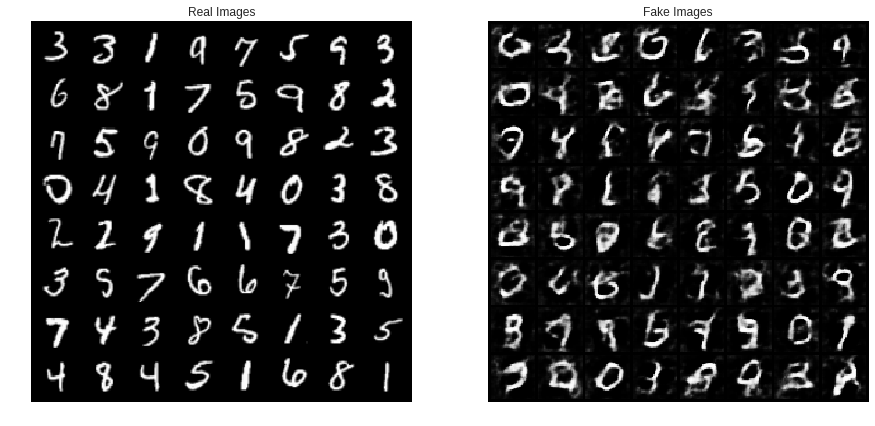

In [0]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

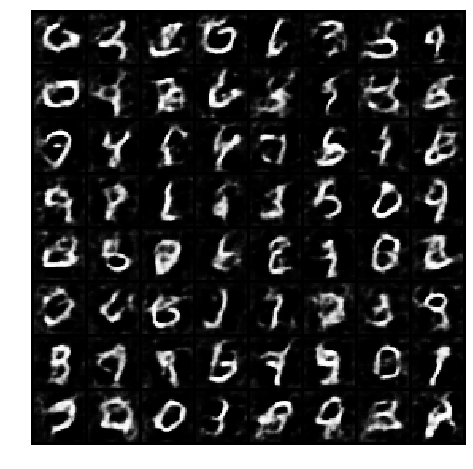

In [0]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

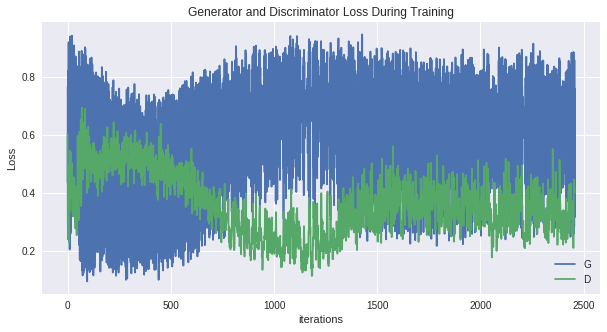

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Saving Model and Data in files and Uploading to Drive


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                 
drive = GoogleDrive(gauth)

In [0]:
def upld_drive(x):  
  model_file = drive.CreateFile({'title' : x})             
  model_file.SetContentFile(x)  
  model_file.Upload()
  drive.CreateFile({'id': model_file.get('id')})

In [0]:
if bool!=True:
  torch.save(netG, 'GenMNIST')
  torch.save(netD, 'DisMNIST')
  torch.save(img_list, 'ImgMNIST')
  torch.save(G_losses, 'GlossMNIST')
  torch.save(D_losses, 'DlossMNIST')
  upld_drive('GenMNIST')
  upld_drive('DisMNIST')
  upld_drive('ImgMNIST')
  upld_drive('GlossMNIST')
  upld_drive('DlossMNIST')

In [0]:
if bool:
  torch.save(netG, 'GenCIFAR10')
  torch.save(netD, 'DisCIFAR10')
  torch.save(img_list, 'ImgCIFAR10')
  torch.save(G_losses, 'GlossCIFAR10')
  torch.save(D_losses, 'DlossCIFAR10')
  upld_drive('GenCIFAR10')
  upld_drive('DisCIFAR10')
  upld_drive('ImgCIFAR10')
  upld_drive('GlossCIFAR10')
  upld_drive('DlossCIFAR10')

In [0]:
netG=torch.load('GenMNIST')
netD=torch.load('DisMNIST')
img_list=torch.load('ImgMNIST')
G_losses=torch.load('GlossMNIST')
D_losses=torch.load('DlossMNIST')

In [0]:
netG=torch.load('lsGenCIFAR10')
netD=torch.load('lsDisCIFAR10')
img_list=torch.load('lsImgCIFAR10')
G_losses=torch.load('lsGlossCIFAR10')
D_losses=torch.load('lsDlossCIFAR10')